### load

In [6]:
## input: 1. summarizedExperiement(SE) obj for chromVAR 2. Jaspar matrix 
## output: 1. motif x cell (z score) 2. plot: ranked           
source("./libs.R")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 15298    13

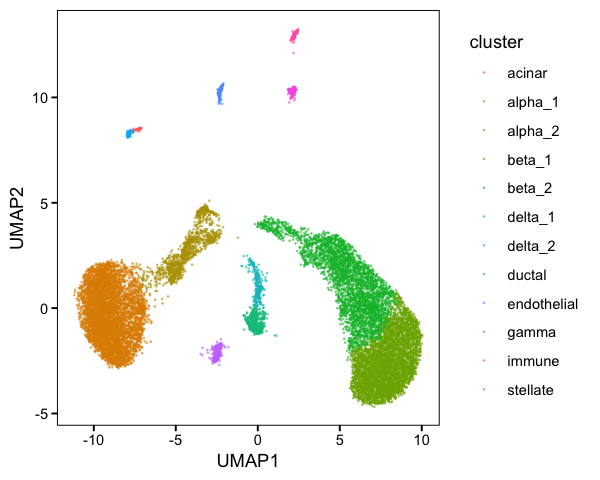

In [8]:
##------------------------------------------------------------
## inputs
##------------------------------------------------------------

options(repr.plot.width = 5, repr.plot.height = 4)

# filter unkonwn

head(input.umap.res, 1)
dim(input.umap.res)
ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr()

In [10]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z, 
    umap.res = input.umap.res, rescale = F, cls = rev(cols.sky), bks = c(-4, 0, 4), 
    ...) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    tmp <- tmp %>% mutate(zval = ifelse(zval > bks[3], bks[3], ifelse(zval < bks[1], 
        bks[1], zval)))
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        shape = 16, ...) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10, family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"


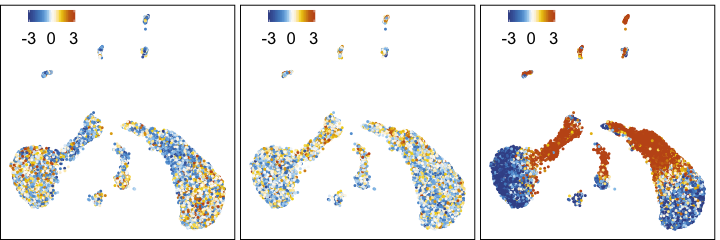

In [11]:
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(c("RFX3", "XBP1", "FOS::JUN"), fun.plot.project.motif, bks = c(-3, 0, 
    3), size = 0.5)
names(ps) <- c("RFX3", "XBP1", "FOS::JUN")
ggarrange(plotlist = ps, ncol = 3)

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"


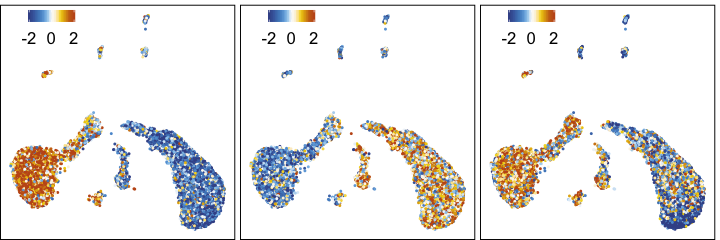

In [12]:
plt.motifs <- c("GATA3", "NKX6-2", "HNF1B")
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(plt.motifs, fun.plot.project.motif, bks = c(-2, 0, 
    2), size = 0.5)
names(ps) <- plt.motifs
ggarrange(plotlist = ps, ncol = 3)

In [13]:
table(input.umap.res%>%pull(cluster))
table(input.umap.res%>%pull(cluster))%>%as.numeric%>%sum


     acinar     alpha_1     alpha_2      beta_1      beta_2     delta_1 
         46        5191        1027        4204        3394         478 
    delta_2      ductal endothelial       gamma      immune    stellate 
        232          80         118         260         140         128 

[1] 15298

In [15]:
input.umap.res[is.na(input.umap.res)] <- 0

### T Tests (a_v_g,b_v_d)

In [16]:
input.chromVar.jaspar.z <- data.table(assays(input.chromVar.res.list$dev)$z,keep.rownames = T)
class(input.chromVar.jaspar.z)
head(rownames(input.chromVar.jaspar.z))

[1] "data.table" "data.frame"

[1] "1" "2" "3" "4" "5" "6"

In [17]:
# aggregate data --------------------------------------------------------------
# melt
input.chromVar.jaspar.z.agg <- melt(input.chromVar.jaspar.z, id = "rn", variable.name = "barcodes", 
    value.name = "zval")

# add celltype
input.chromVar.jaspar.z.agg <- merge(input.chromVar.jaspar.z.agg, input.umap.res) 
head(input.chromVar.jaspar.z.agg,1)
dim(input.chromVar.jaspar.z.agg)
dim(input.chromVar.jaspar.z)
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))

barcodes,rn,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0004.1_Arnt,-1.566904,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 8857542      15

[1]   579 15299


     acinar       alpha        beta       delta      ductal endothelial 
      26634     3600222     4399242      411090       46320       68322 
      gamma      immune    stellate 
     150540       81060       74112 

In [18]:
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg[complete.cases(input.chromVar.jaspar.z.agg), 
   ] %>% separate(rn, into = c("id", "name"), sep = "_")
range(input.chromVar.jaspar.z.agg$zval)
dim(input.chromVar.jaspar.z.agg)
head(input.chromVar.jaspar.z.agg,1)

[1] -20.16193  31.35658

[1] 8857500      16

barcodes,id,name,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0004.1,Arnt,-1.566904,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


In [19]:
motif ='NFIL3'
table(input.chromVar.jaspar.z.agg %>% filter(name == motif)%>%pull(cell_type_overall))
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))


     acinar       alpha        beta       delta      ductal endothelial 
         46        6218        7598         710          80         118 
      gamma      immune    stellate 
        260         140         128 


     acinar       alpha        beta       delta      ductal endothelial 
      26634     3600217     4399223      411089       46319       68322 
      gamma      immune    stellate 
     150540       81044       74112 

In [20]:
require(parallel)
celltype.test.all <- list(alpha_vs_gamma = c("alpha", "gamma"), beta_vs_delta = c("beta", 
    "delta"))
ttest.res <- do.call(rbind, lapply(names(celltype.test.all), function(ntest) {
    # cells <- c('beta', 'delta')
    celltype.test <- celltype.test.all[[ntest]]
    test.motifs <- input.chromVar.jaspar.z.agg %>% filter(cell_type_overall %in% 
        celltype.test) %>% pull(name) %>% unique
    ttest.res <- do.call(rbind, mclapply(test.motifs, function(motif) {
        pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
            celltype.test)
        test.res <- t.test(pd %>% filter(cell_type_overall == celltype.test[1]) %>% 
            select(zval), pd %>% filter(cell_type_overall == celltype.test[2]) %>% 
            select(zval))
        (data.frame(`motif` = motif, mean_x = test.res$estimate[1], mean_y = test.res$estimate[2], 
            pval = test.res$p.value/2))
    }, mc.cores = 10)) %>% mutate(test = ntest)
}))
head(ttest.res,1)
head(ttest.res%>%filter(test=='beta_vs_delta'),1)

motif,mean_x,mean_y,pval,test
<fct>,<dbl>,<dbl>,<dbl>,<chr>
Arnt,0.1574304,-0.354999,4.480141e-15,alpha_vs_gamma


motif,mean_x,mean_y,pval,test
<fct>,<dbl>,<dbl>,<dbl>,<chr>
Arnt,-0.1974729,-0.2690885,0.04236309,beta_vs_delta


In [21]:
ttest.res <- ttest.res %>% group_by(test) %>% mutate(FDR = p.adjust(pval, "BH"), 
    padj = p.adjust(pval, "bonferroni"))

ttest.res <- ttest.res %>% mutate(x = unlist(strsplit(test, split = "_vs_"))[1], 
    y = unlist(strsplit(test, split = "_vs_"))[2]) %>% mutate(enrichedIn = ifelse(mean_x > 
    mean_y, x, y)) %>% mutate(lfdr = ifelse(enrichedIn %in% c("alpha", "beta"), log10(FDR), 
    -log10(FDR))) %>% group_by(test) %>% arrange(lfdr) %>% rowid_to_column("rank") %>% 
    mutate(rank = ifelse(rank <= 579, rank, rank - 579)) %>% left_join(input.chromVar.jaspar.z.agg %>% 
    select(id, name) %>% distinct, by = c(motif = "name")) %>% select(rank, motif, 
    id, x, y, test, mean_x, mean_y, enrichedIn, pval, FDR, padj, lfdr)

fwrite(ttest.res, "~/Dropbox (UCSD_Epigenomics)/workReports/2019-08-27_islet/chromVar_ttest_res.csv")

#### add motif annotation

In [48]:
input.chromVar.jaspar.z.agg%>%head(1)

barcodes,id,name,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0004.1,Arnt,-1.566904,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


In [35]:
ttest.res %>% head(1)
ttest.res %>% pull(id) %>% unique %>% length
ttest.res %>% nrow

rank,motif,id,x,y,test,mean_x,mean_y,enrichedIn,pval,FDR,padj,lfdr
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,NRL,MA0842.1,beta,delta,beta_vs_delta,-0.1351892,-1.215561,beta,1.907675e-96,1.104544e-93,1.104544e-93,-92.95682


[1] 579

[1] 1158

In [55]:
## from one vs other prevous.res <-
ttest.res<- ttest.res %>% left_join(fread("../figures/Fig1/subfigs/fig1E_one_vs_other.csv") %>% 
    select(jaspar.id, family.id, family.name, class.id, class.name, superclass.id, 
        superclass.name) %>% unique, by = c(id = "jaspar.id"))
ttest.res%>%head(1)
ttest.res%>%nrow

rank,motif,id,x,y,test,mean_x,mean_y,enrichedIn,pval,FDR,padj,lfdr,family.id,family.name,class.id,class.name,superclass.id,superclass.name
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1,NRL,MA0842.1,beta,delta,beta_vs_delta,-0.1351892,-1.215561,beta,1.907675e-96,1.104544e-93,1.104544e-93,-92.95682,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


[1] 1228

In [60]:
(all.test <- c("beta_vs_delta_d", "beta_vs_delta_b", "alpha_vs_gamma_g", "alpha_vs_gamma_a"))
names(all.test) <- c("delta", "beta", "gamma", "alpha")
# ttest.res <- ttest.res %>% group_by(test) %>% arrange(enrichedIn, pval,
# desc(mean_x))
ttest.res.list <- lapply(names(all.test), function(ntest) ttest.res %>% filter(test == 
    sub("_[bdga]$", "", all.test[[ntest]]) & enrichedIn == ntest) %>% select(-rank, 
    -lfdr) %>% group_by(test) %>% arrange(enrichedIn, FDR))
names(ttest.res.list) <- as.character(all.test)
require(writexl)
write_xlsx(ttest.res.list, "../figures/Fig1/subfigs/fig1E_one_vs_other.xlsx")
fwrite(ttest.res, "../figures/Fig1/subfigs/fig1E_one_vs_other.csv")
system(" open ../figures/Fig1/subfigs/fig1E_one_vs_other.xlsx")

[1] "beta_vs_delta_d"  "beta_vs_delta_b"  "alpha_vs_gamma_g" "alpha_vs_gamma_a"